## Arabic Handwritten Character Search**


# Download Data

### Query Image

In [ ]:
import os

# # Set KaggleHub cache to a directory inside /content/
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

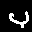

In [25]:
import kagglehub
from PIL import Image
import os

path = kagglehub.dataset_download("mohammad2012191/character")
raw_query_image = Image.open(os.path.join(path,"char.png"))
raw_query_image

### Arabic Characters Dataset

In [26]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("mohammad2012191/arabic-chars")

print("Path to dataset files:", dataset_path)

Path to dataset files: /content/data/datasets/mohammad2012191/arabic-chars/versions/3


# Build a custom dataset class for the data

In [ ]:
import os
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class ArabicHandwritingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = glob.glob(os.path.join(root_dir, '**/*.png'), recursive=True) # Use glob to extract images paths from root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths) # Just return how many images we have

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path) # Write a line to load the image from img_path
        label = os.path.basename(os.path.dirname(img_path)) # Write a line to extract the label from img_path
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((32, 32)), # Resize to 32*32
    transforms.ToTensor(),# Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize using Imagenet mean and std
])


train_dataset = ArabicHandwritingDataset(root_dir=os.path.join(dataset_path,"chars images"), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # TO DO
print(f"Total images: {len(train_dataset)}")



transformed_query_image = transform(raw_query_image) # Apply the transform to raw_query_image

Total images: 668


# Use EfficientNet B3 to extract features.

### Extract Features for the dataset images

In [ ]:
import torch
from torchvision.models import efficientnet_b3

# Load pretrained efficientnet_b3 model
model = efficientnet_b3(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Use efficientnet_b3 to extract features
all_features = []
all_images = []
with torch.no_grad(): # Disable gradient calculation during feature extraction
    for images, _ in train_loader:
        features = model.features(images)  # Extract features using the features part of the model
        all_features.append(features)
        all_images.append(images)

    #Extract features for the query image
    query_features = model.features(transformed_query_image.unsqueeze(0))


# Convert features to numpy and concatenate them.
import numpy as np
all_features = torch.cat(all_features, dim=0).numpy()
all_images = torch.cat(all_images, dim=0).numpy()
query_features = query_features.numpy()


### Extract Features for the query image

In [ ]:
query_image_feats = model.features(transformed_query_image.unsqueeze(0)).detach().numpy()
# I need to detach the tensor to convert to numpy

# Get the indices of top 5 images using Cosine Similarity

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Reshape the features to 2D before calculating cosine similarity
all_features_2d = all_features.reshape(all_features.shape[0], -1)  # Reshape to (num_samples, num_features) # -1 === num_of_features
query_image_feats_2d = query_image_feats.reshape(1, -1)  # Reshape to (1, num_features)


# Calculate cosine similarity between query image features and all dataset image features
similarities = cosine_similarity(query_image_feats_2d, all_features_2d)

# Get the indices of the top 5 most similar images
top_5_indices = np.argsort(similarities[0])[::-1][:5]

top_5_indices

array([191, 128, 328, 568,  93])

# Fix the errors in the following code to plot the most 5 similar images

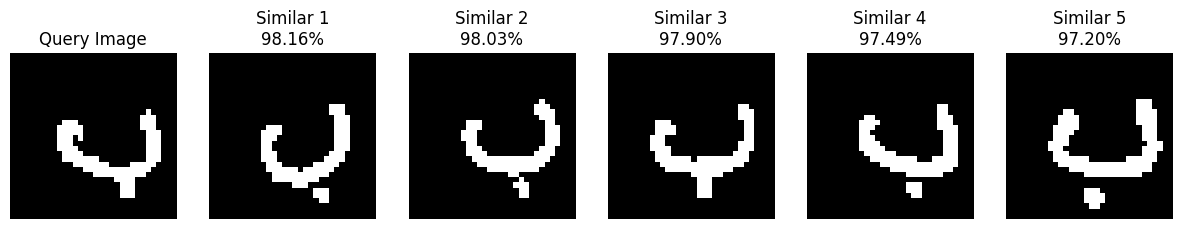

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Display query & retrieved images with similarity scores
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
# Query image
axes[0].imshow(np.transpose(transformed_query_image.squeeze(0).numpy(), (1, 2, 0))) 
axes[0].set_title("Query Image")
axes[0].axis("off")
# Retrieved similar images with similarity scores
for i, idx in enumerate(top_5_indices):
    image = all_images[idx]
    similarity_score = similarities[0][idx]  # Get similarity score
    axes[i + 1].imshow(np.transpose(image, (1, 2, 0))) 
    axes[i + 1].set_title(f"Similar {i+1}\n{100*similarity_score:.2f}%")  # Show similarity score
    axes[i + 1].axis("off")
plt.show()